# Strategies trading results comparison

In [1]:
%%capture
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Download trading data
Download the data from cloud, read strategies databases for analysis

In [2]:
plot_figsize=(10,5)
#strategies=["SimpleKerasStrategy", "LSTMStrategy", "LSTMStrategy2"]
strategies=["SimpleKerasStrategy", "LSTMStrategy2"]

In [3]:
import os
from datetime import datetime

os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
print(f"Download completed at {datetime.utcnow()} UTC.")

receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-06-20_BTC-USDT_X.csv
LSTMStrategy/Xy/2023-06-20_BTC-USDT_data.csv
LSTMStrategy/Xy/2023-06-20_BTC-USDT_y.csv
LSTMStrategy/weights/2023-06-20T06:10:15.273417.data-00000-of-00001
LSTMStrategy/weights/2023-06-20T06:10:15.273417.index
LSTMStrategy/weights/checkpoint
LSTMStrategy2/LSTMStrategy2.db
LSTMStrategy2/Xy/2023-06-20_BTC-USDT_X.csv
LSTMStrategy2/Xy/2023-06-20_BTC-USDT_data.csv
LSTMStrategy2/Xy/2023-06-20_BTC-USDT_y.csv
LSTMStrategy2/weights/2023-06-20T06:10:25.557389.data-00000-of-00001
LSTMStrategy2/weights/2023-06-20T06:10:25.557389.index
LSTMStrategy2/weights/checkpoint
SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy/Xy/2023-06-20_BTC-USDT_X.csv
SimpleKerasStrategy/Xy/2023-06-20_BTC-USDT_data.csv
SimpleKerasStrategy/Xy/2023-06-20_BTC-USDT_y.csv
SimpleKerasStrategy/weights/2023-06-20T06:10:29.490784.data-00000-of-00001
SimpleKerasStrategy/weights/2023-06-20T06:10:29.490784.index
SimpleK

In [4]:
import pandas as pd
import numpy as np
import sqlite3

def get_balance(strategy: str):
    """ Read balance history from data"""
    
    data_dir=f"../data/yandex-cloud"
    account_dir=f"{data_dir}/{strategy}/account"
    #file_path = sorted([f for f in os.listdir(account_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
    files = sorted([f for f in os.listdir(account_dir) if f.endswith(f".csv")])
    return pd.concat([pd.read_csv(f"{account_dir}/{f}", parse_dates=True, index_col="time") for f in files]).sort_index()
    

def get_trades(strategy: str):
    """ Read strategy trades from related sqlite3 database"""
    data_dir=f"../data/yandex-cloud"
    fee=0.000102
    quantity_coeff=0.001

    db_path=f"{data_dir}/{strategy}/{strategy}.db"
    print(f"Get {strategy} trades from {db_path}")

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"]*quantity_coeff,
                                (trades["open_price"]-trades["close_price"])*trades["quantity"]*quantity_coeff,
                               )
    trades["profit"] = trades["profit"] - fee*(trades["open_price"] + trades["close_price"])*trades["quantity"]*quantity_coeff
    trades["cum_profit"] = trades["profit"].cumsum()
    open_time=trades["open_time"].iloc[-1]    
    close_time=trades["close_time"].iloc[-1]    
    print(f"{strategy} last trade open: {open_time}, close: {close_time}\n")  
    
    return trades

# Main data structure: strategy -> trades dictionary
strategies_trades = dict([(strategy, get_trades(strategy)) for strategy in strategies])
strategies_balances = dict([(strategy, get_balance(strategy)) for strategy in strategies])



Get SimpleKerasStrategy trades from ../data/yandex-cloud/SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy last trade open: 2023-06-20 05:41:16.536000, close: NaT

Get LSTMStrategy2 trades from ../data/yandex-cloud/LSTMStrategy2/LSTMStrategy2.db
LSTMStrategy2 last trade open: 2023-06-20 01:11:37.372000, close: NaT



In [5]:
trades=strategies_trades.get("SimpleKerasStrategy")
#trades.dropna().tail()
trades.tail()
#trades[trades["close_order_id"].isnotnone()].tail()
#sb=strategies_balances["SimpleKerasStrategy"]    
#sb.tail(100)

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,status,profit,cum_profit
50,51,BTC-USDT,SELL,2023-06-20 02:30:22.474,26889.9,1120661919418605568,27172.2,27142.3,"1120661919435382785,1120661919435382784",None,1.0,2023-06-20 02:35:33.389,26909.7,1120663215568601088,closed,-0.025288,-0.122996
51,52,BTC-USDT,BUY,2023-06-20 03:09:33.655,26930.1,1120671780988993537,26647.4,26676.5,"1120671781005770753,1120671781005770752",None,1.0,2023-06-20 03:34:45.946,26916.6,1120678123060346880,closed,-0.018992,-0.141988
52,53,BTC-USDT,BUY,2023-06-20 05:02:14.111,26943.3,1120700136392990720,26660.5,26690.4,"1120700136409767937,1120700136409767936",None,1.0,2023-06-20 05:07:25.745,26961.0,1120701435308163072,closed,0.012202,-0.129786
53,54,BTC-USDT,SELL,2023-06-20 05:24:42.477,26951.2,1120705791854092288,27230.3,27200.3,"1120705791870869505,1120705791870869504",None,1.0,2023-06-20 05:27:12.370,26931.0,1120706411770167296,closed,0.014704,-0.115082
54,55,BTC-USDT,BUY,2023-06-20 05:41:16.536,26871.2,1120709961248485376,26588.3,26634.7,"1120709961261068289,1120709961261068288",None,1.0,NaT,NaN,None,opened,NaN,NaN


## Balance history

In [6]:
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
import seaborn as sns
sns.set_theme()


def prepare_balance(df):
    del df["available"]
    df=df[df["balance"].notnull()].dropna()
    base = 25
    df = df[df["balance"].between(20,35)]
    #    df["balance_diff"]=df["balance"].diff()
    #df=df[1:] # Hack for specific df of 2023-06-11
    #df=df.reset_index()
    #df["delta"]=df["balance"] - df["balance"].shift(2))/df["balance"] < 0.2]
    #df["balance_diff"] = df["balance"].diff()
    #print(df.balance.diff())
    #df=df[df.index%2==1]
    #df=df[abs(df["balance"].diff()/df["balance"])< 0.3]
    #df["balance_diff_percent"] = abs(df["balance"].diff())/df["balance"]
#     df["balance_diff"] = df["balance"].diff().abs().copy()

#     df = df[df["balance_diff"] < 5]
#     #df=df[df["balance_diff_percent"].between(0, 0.5, "right")]
    #df=df[df["balance_diff_percent"]> 0]
    
#     df=df.set_index("datetime", drop=False)
#     print(df[["balance", "balance_diff"]].tail(100))
    return df

def plot_strategies_balances(strategies, asset):
    """ Plot all strategies balance history"""
    
    # Charts for each strategy
    for strategy in strategies:
        strategy_df=strategies_balances[strategy]

        # Chart for each asset
        for asset in strategy_df["asset"].unique():
            asset_df=strategy_df[strategy_df["asset"]==asset].copy()
            asset_df["datetime"]=asset_df.index

            asset_df=prepare_balance(asset_df)
            
            #plt.figure(figsize=plot_figsize)
            asset_df=asset_df[["datetime", "balance"]].dropna()
            title=f"{strategy} {asset.upper()} balance"
            px.line(asset_df, "datetime", "balance", title=title) .update_traces(mode='lines+markers').show()

#             title=f"{strategy} {asset.upper()} balance diff"
#             px.line(asset_df, "datetime", "balance_diff", title=title) .update_traces(mode='lines+markers').show()

            
#             plt.plot("datetime", "balance", data=asset_df[["datetime", "balance"]].dropna())
#             plt.title(f"{strategy} {asset} balance")
#             plt.show()

        
    
plot_strategies_balances(strategies_balances, "usdt")
#df=strategies_balances["SimpleKerasStrategy"]

# df=df[df["asset"]=="usdt"].copy()
# del df["available"]
# df=df[df["balance"].notnull()].dropna()
# #print(list(np.arange(0,len(df))[:10]))
# df["num"] = np.arange(0,len(df))
# df["balance_prev"] = df["balance"].shift()
# df["balance_diff"]=df["balance"].diff().abs()/df["balance"]
#df=df[df["balance_diff"]]
#df=df[["datetime","balance"]]


# df["diff"]=df[["balance"]].diff()
# df=df[df["diff"]>0]
# df=df[df["diff"]<10]
#df["balance"].plot()

#df["diff"] = df["balance"].diff()
#df.head()
#print(strategies_balances)



## Cumulative profit

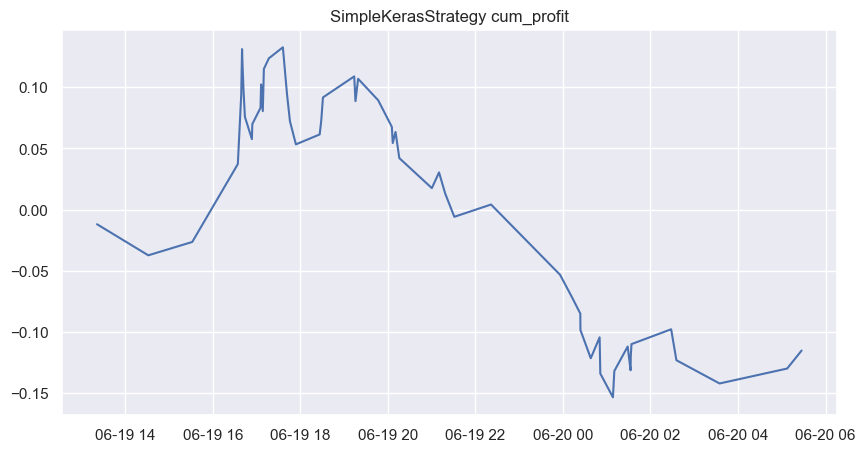

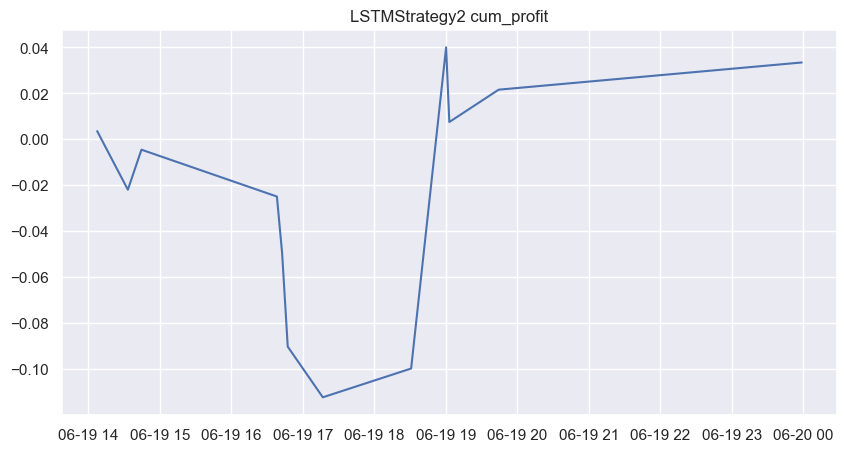

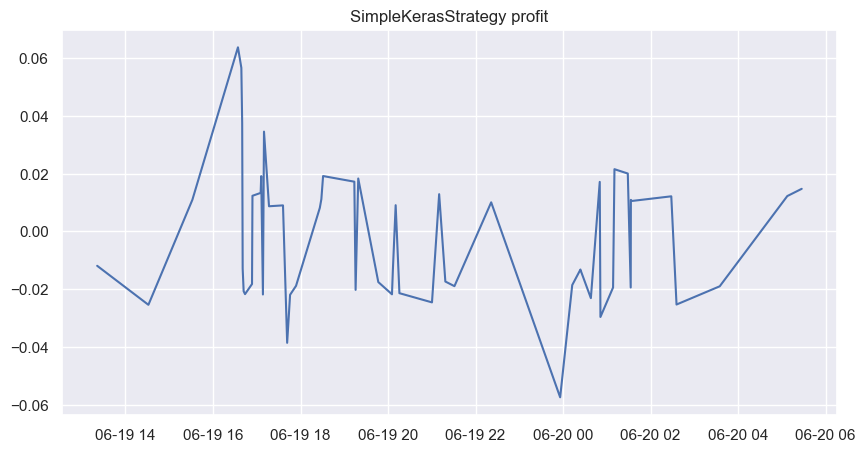

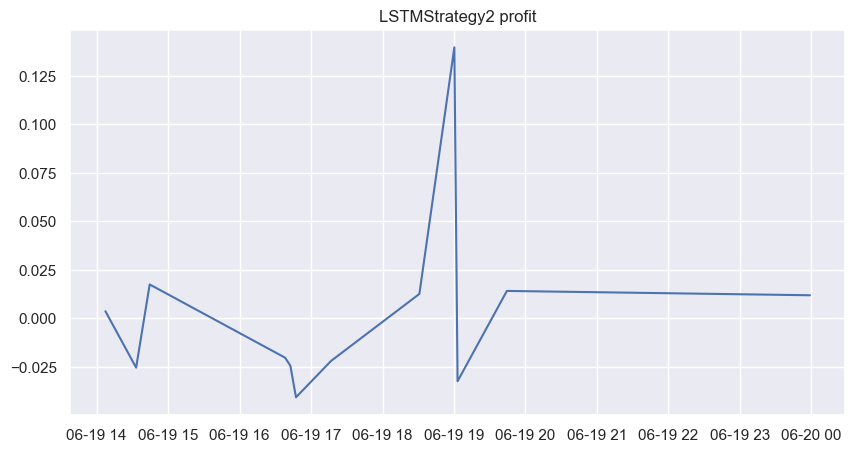

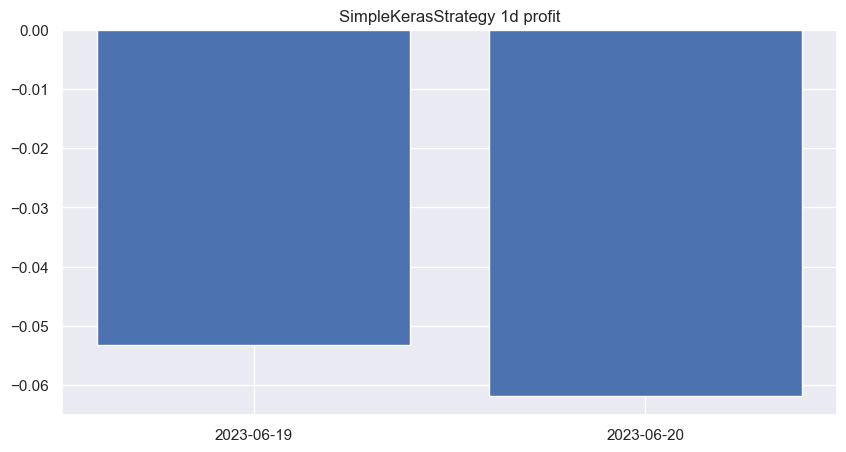

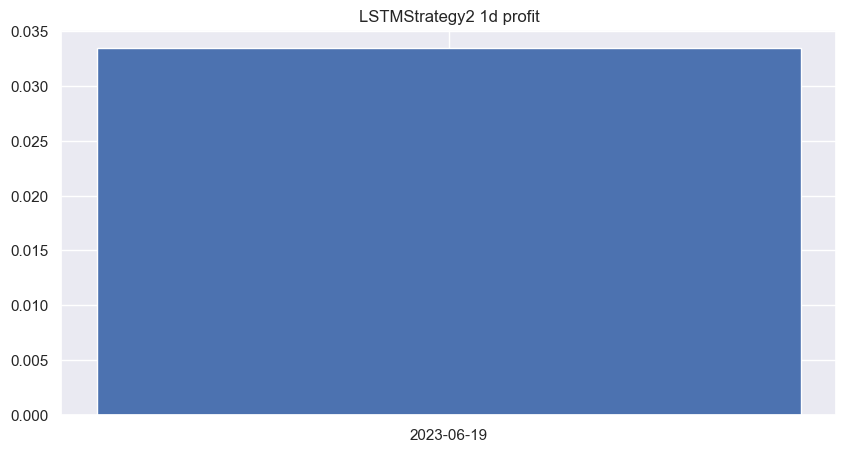

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_theme()
#paper, notebook, talk, poster

import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "plotly_mimetype+notebook"
import plotly.graph_objects as go

# Align the plot width    
plot_figsize=(10,5)
sns.set_style("darkgrid")


def plot_profit_plotly(strategy, trades, col):
    """ Plot strategy profit using plotly"""
    px.line(trades, x="close_time", y=col, title=f"{strategy} {col}").update_traces(mode='lines+markers').show()
    
def plot_profit_sns(strategy, trades, col):
    """ Plot strategy profit using sns"""
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=trades, x="close_time", y=col).set_title(f"{strategy} {col}")
    plt.show()

def plot_profit_plt(strategy, trades, col):
    """ Plot profits using matplotlib """
    plt.figure(figsize=(10,5))
    plt.plot("close_time", col, data=trades)
    plt.title(f"{strategy} {col}")
    plt.show()
    
def plot_strategies_profits(plot_func, strategies_trades, col):
    """ Plot all strategies profit using given func"""
    
    for strategy in strategies:
        trades=strategies_trades[strategy]
        plot_func(strategy, trades, col)

def plot_strategies_daily_profits(plot_func, strategies_trades, col):
    """ Plot daily values"""
    interval="1d"
    for strategy in strategies:
        trades = strategies_trades[strategy]
        resampled=trades.set_index("close_time")[["profit", "cum_profit"]] \
            .resample(interval) \
            .agg({"profit": "sum", "cum_profit": "last"})\
            .reset_index()
        resampled["close_time"] = resampled["close_time"].astype(str)
        plt.figure(figsize=plot_figsize)
        plt.bar("close_time", col, data=resampled)
        plt.title(f"{strategy} {interval} {col}")
        plt.show()
        
# Plot profit and cumulative profit for each strategy
plot_strategies_profits(plot_profit_plt, strategies_trades, "cum_profit")
plot_strategies_profits(plot_profit_plt, strategies_trades, "profit")
plot_strategies_daily_profits(plot_profit_plt, strategies_trades, "profit")



## Buy, sell trade counts

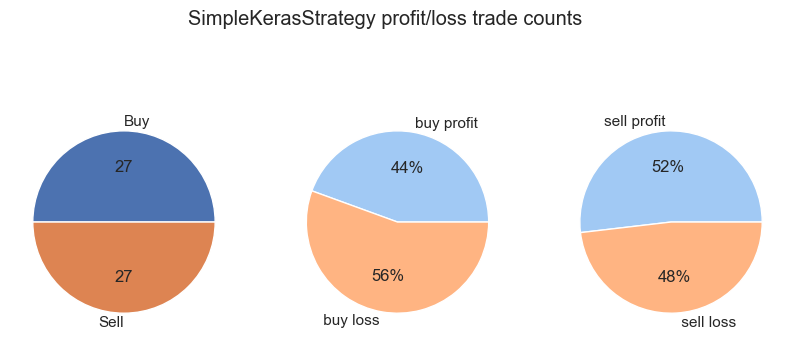

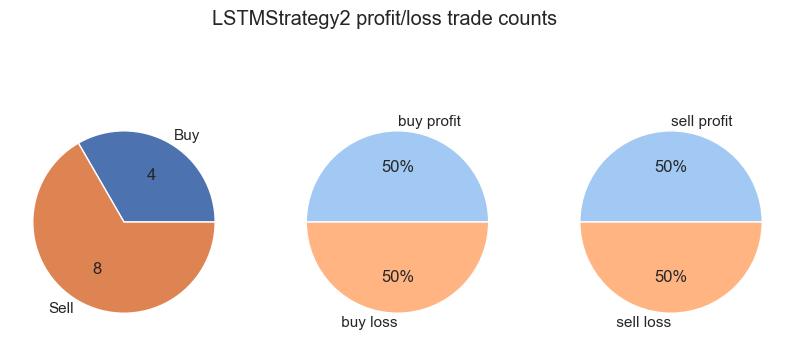

In [8]:
def plot_trade_counts(strategy, trades):
    trades = trades[:-1]
    buy_sell_counts = trades["side"].value_counts()
    total=len(trades)
    colors = sns.color_palette('pastel')[0:5]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle(f'{strategy} profit/loss trade counts')
    # Buy/sell counts
    ax1.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
            labels=["Buy","Sell"], \
            autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # Buy profit/loss counts
    ax2.pie([len(trades[(trades["side"]=="BUY") & (trades["profit"]>0)]),\
            len(trades[(trades["side"]=="BUY") & (trades["profit"]<0)]) \
            ],
            labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
    # Sell profit/loss counts
    ax3.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)]),\
            len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)]) \
            ],
            labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)
    fig.subplots_adjust(top=1)

    plt.show()



for strategy in strategies_trades:
    plot_trade_counts(strategy, strategies_trades[strategy])

## Compare strategies profits

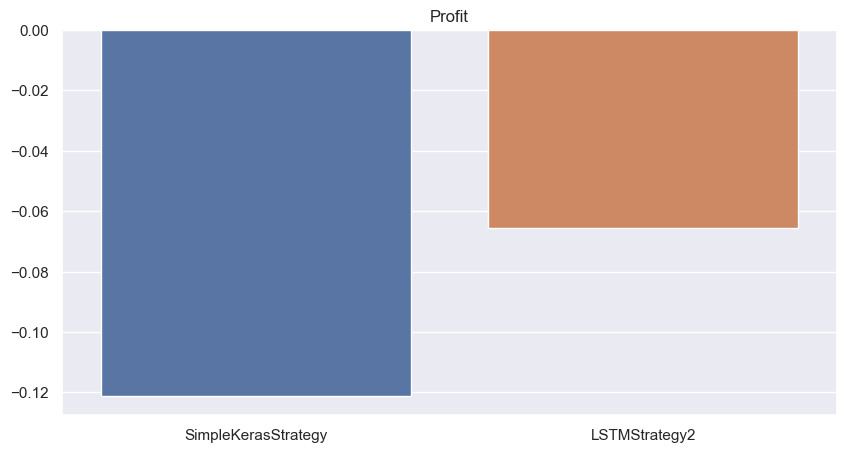

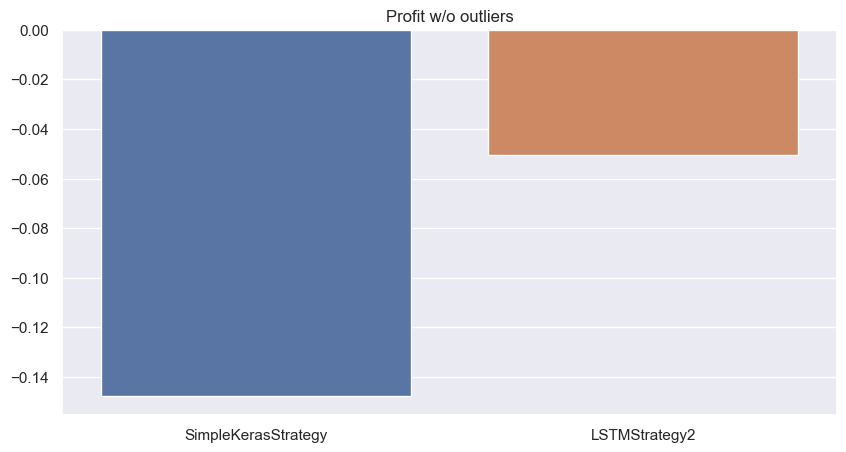

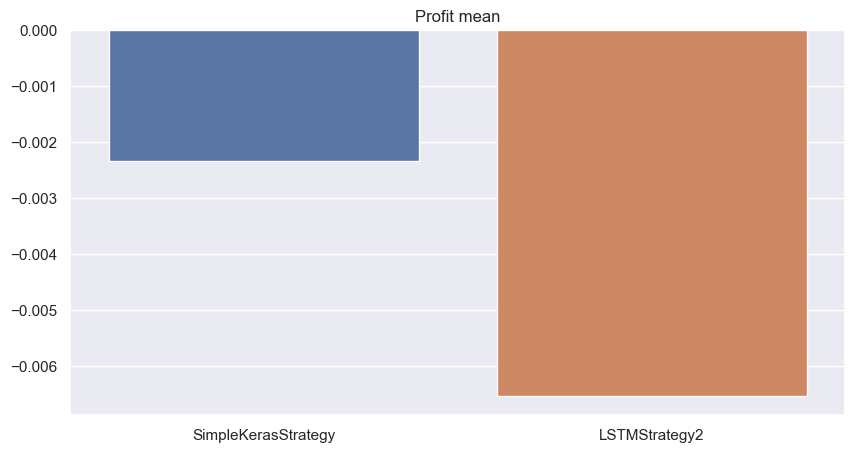

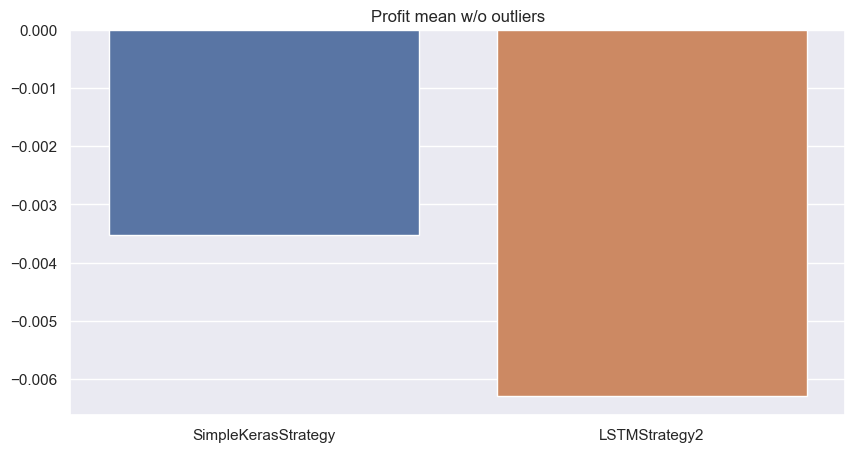

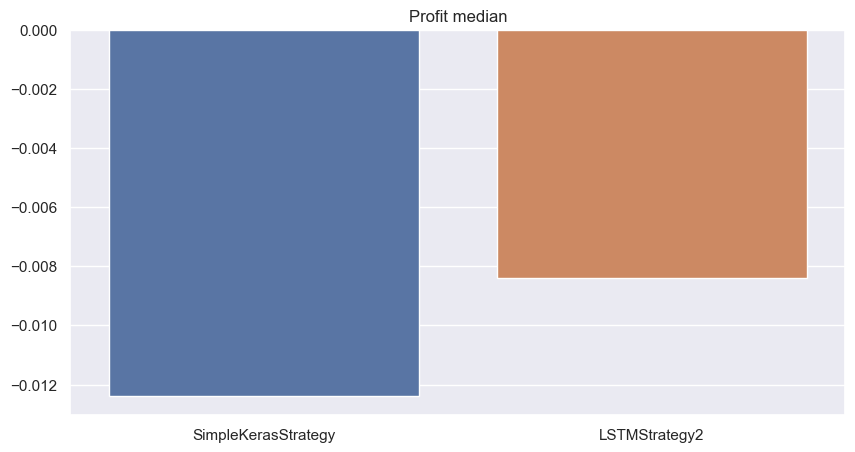

In [9]:
def plot_comparison(title, strategies_trades, y_func, quantiles=[0,1]):
    """ Comparison bar plot: x=strategy, y=summary function for the strategy"""
    data={"strategy":[], "profit":[]}
    #strategies_data = dict([(strategy,get_trades(strategy)) for strategy in strategies])
    for strategy in strategies:
        #val = get_trades(strategy)["profit"].sum()
        trades = strategies_trades[strategy]
        q_low = trades["profit"].quantile(quantiles[0])
        q_hi  = trades["profit"].quantile(quantiles[1])
        trades_filtered = trades[(trades["profit"] < q_hi) & (trades["profit"] > q_low)]      
        #trades_filtered=trades
        val = y_func(trades_filtered)
        data["strategy"].append(strategy)
        data["profit"].append(val)
    plt.figure(figsize=plot_figsize)
    sns.barplot(data=data, x="strategy", y="profit").set_title(title)
    plt.show()
    
q_outliers = [0.1, 0.9]
plot_comparison("Profit", strategies_trades, lambda trades: trades["profit"].sum())
plot_comparison("Profit w/o outliers", strategies_trades, lambda trades: trades["profit"].sum(), quantiles=q_outliers)
plot_comparison("Profit mean", strategies_trades, lambda trades: trades["profit"].mean())
plot_comparison("Profit mean w/o outliers", strategies_trades, lambda trades: trades["profit"].mean(), quantiles=q_outliers)
plot_comparison("Profit median", strategies_trades, lambda trades: trades["profit"].median())


### Buy, sell profit

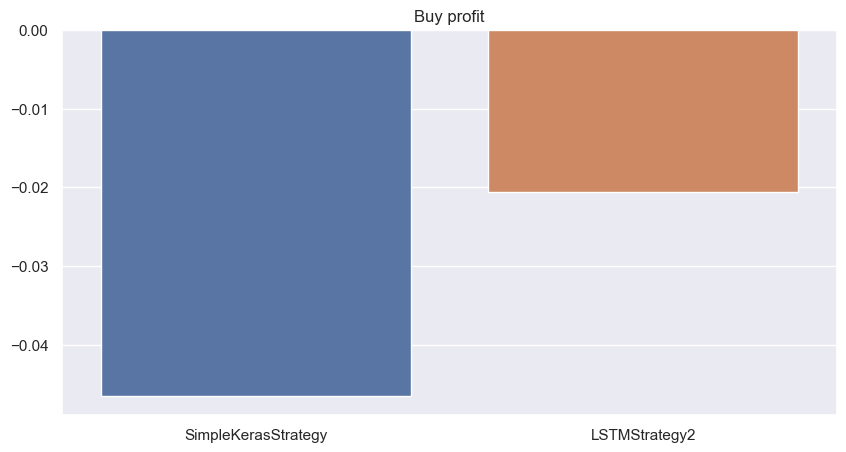

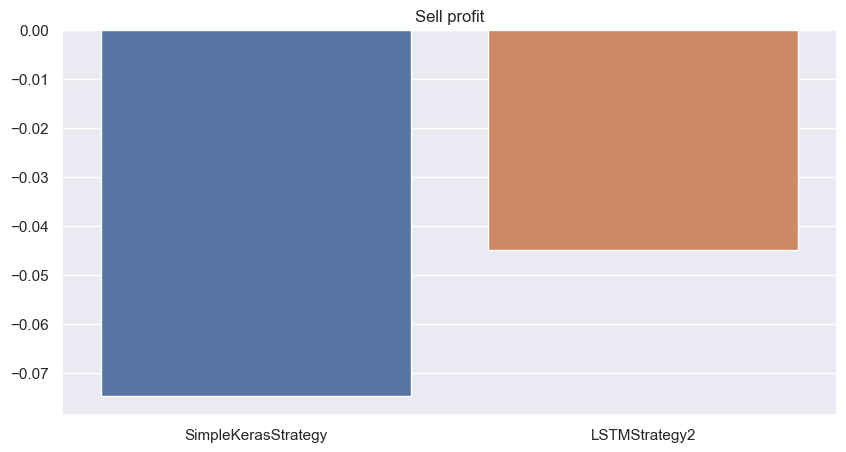

In [10]:
plot_comparison("Buy profit", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].sum())
plot_comparison("Sell profit", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].sum())


### Buy, sell mean profit

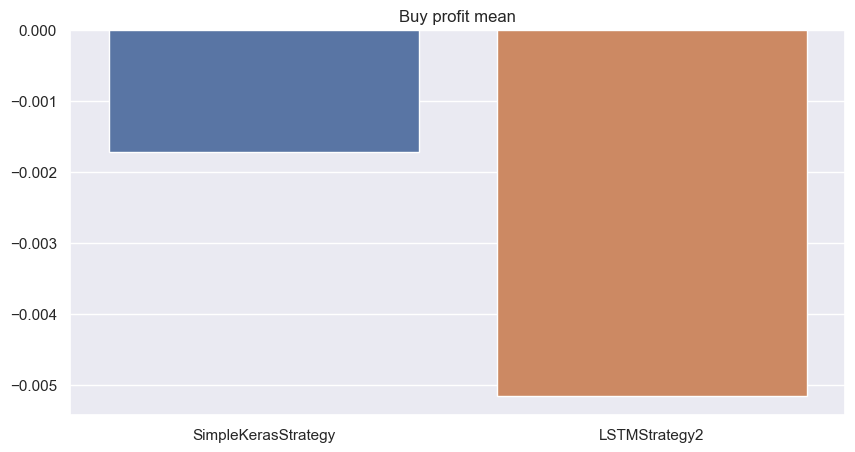

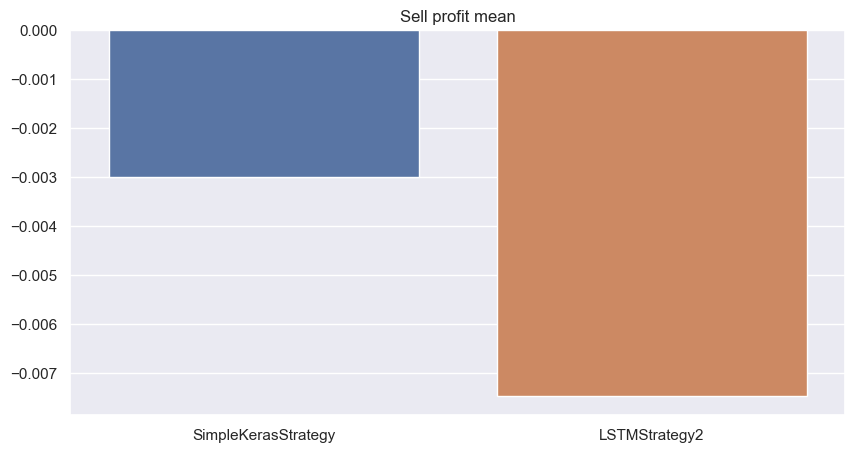

In [11]:
plot_comparison("Buy profit mean", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].mean())
plot_comparison("Sell profit mean", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].mean())


### Buy, sell median profit

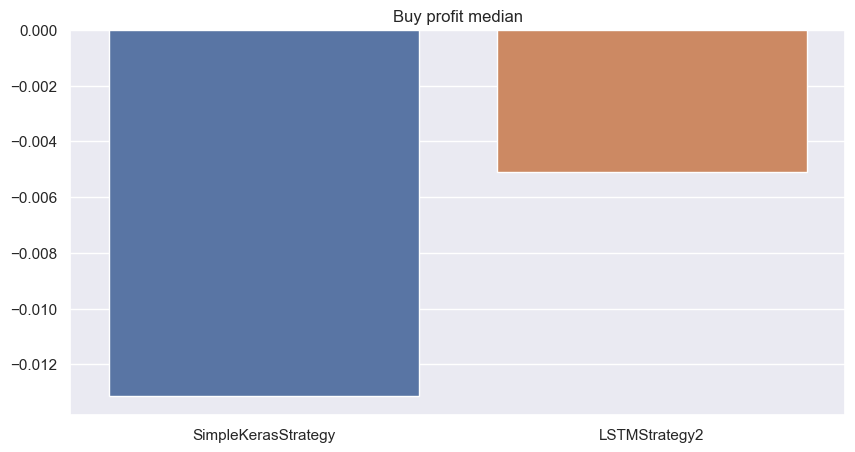

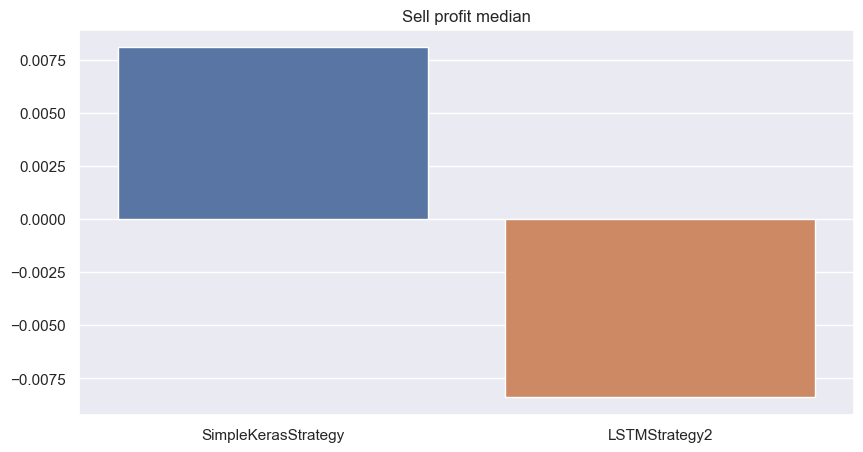

In [12]:
plot_comparison("Buy profit median", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].median())
plot_comparison("Sell profit median", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].median())


## Profit summary

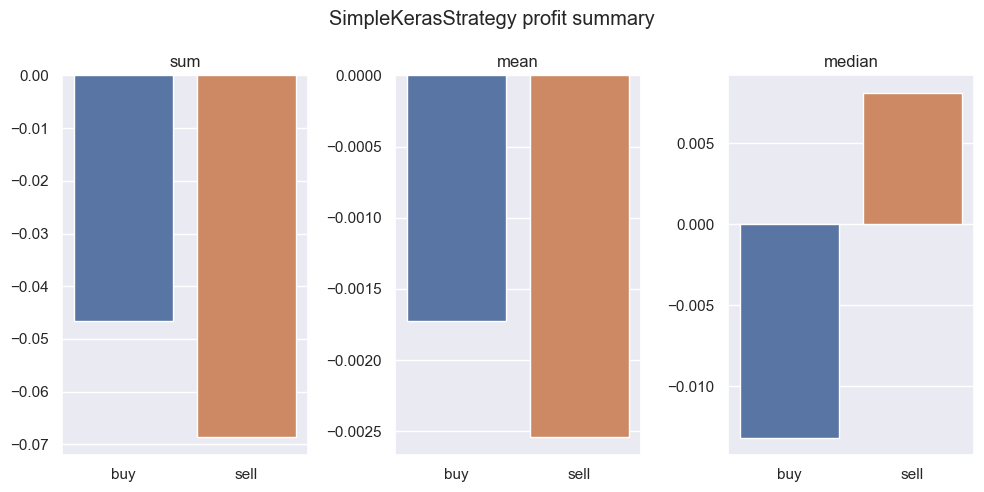

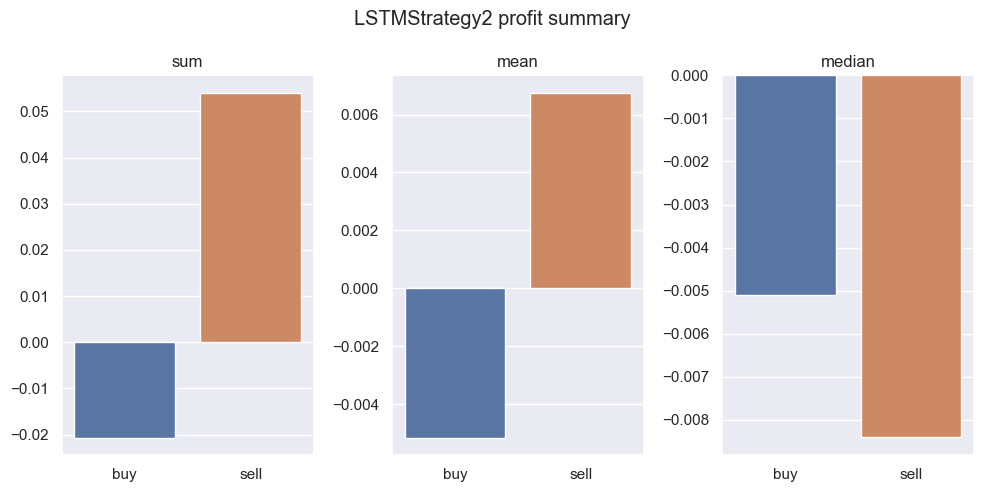

In [13]:
def plot_strategy_profit_sum(strategy, trades):
    """ Profit statistics: summary, average """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle(f'{strategy} profit summary')
    
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]

    # Plots
    sns.barplot(x=["buy", "sell"], y = [buy_profit.sum(), sell_profit.sum()], ax=ax1).set_title("sum")
    sns.barplot(x=["buy", "sell"], y = [buy_profit.mean(), sell_profit.mean()], ax=ax2).set_title("mean")
    sns.barplot(x=["buy", "sell"], y = [buy_profit.median(), sell_profit.median()], ax=ax3).set_title("median")
    fig.tight_layout()
    plt.show()

def plot_profit_sum(strategies_trades):
    """ Plot profit statistics for all strategies"""
    for strategy in strategies_trades:
        plot_strategy_profit_sum(strategy, strategies_trades[strategy])


        
plot_profit_sum(strategies_trades)        
